# Activations visualized - part 2

gets saved acts and grads, reduces dimensions, draws charts

In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams.update({
        "font.family": "Times New Roman",
        "axes.labelsize": 18,
        "font.size": 18,
        "legend.fontsize": 18,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
})


In [1]:
%env CUDA_VISIBLE_DEVICES=0
%env OMP_NUM_THREADS=16 
%env MKL_NUM_THREADS=16 
# %load_ext autoreload
# %autoreload 2

env: CUDA_VISIBLE_DEVICES=0
env: OMP_NUM_THREADS=16
env: MKL_NUM_THREADS=16


In [3]:
import sys, pathlib, os
sys.path.append(str(pathlib.Path('./src').resolve()))

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
device = torch.device('cuda:0')

from tqdm.auto import tqdm, trange
print(f"{torch.__version__=}, {transformers.__version__=}, {device=}")


from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

torch.__version__='2.0.1', transformers.__version__='4.33.2', device=device(type='cuda', index=0)


In [5]:
from utils_args import parse_args, task_to_keys
from utils_data import get_data, preprocess_datasets
from utils_trainer import TrainerWithMetrics
from utils_model import (
    detect_last_checkpoint,
    get_base_model,
    get_model_multiple_loras,
    get_tokenizer,
    ModelWithMultipleLoras,
    change_active_adapter
)

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def reduce_data_dim(data, method='pca', n_components=2):
    if method.lower() == 'pca':
        pca = PCA(n_components=n_components)
        data = pca.fit_transform(data)
    # TSNE IS SLOW
    elif method.lower() == 'tsne':
        tsne = TSNE(n_components=n_components)
        if data.shape[-1] > 50:
            data = reduce_data_dim(data, method='pca', n_components=32)
        data = tsne.fit_transform(data)
    return data
    

def plot_act_grad(repacked_data, labels, step=None, method='pca'):
    
    fig, axs = plt.subplots(2, 2, figsize=(10,6))

    # labels = p.label_ids
    for k, ax in zip(('fwd_0', 'fwd_1'), axs[0]):
        data = reduce_data_dim(repacked_data[k].detach().cpu(), method=method)
        ax.scatter(data[:,0], data[:,1], c=labels, cmap='viridis', alpha=0.6)
        ax.set_title(k)

    for k, ax in zip(('back_0', 'back_1'), axs[1]):
        data = reduce_data_dim(repacked_data[k].detach().cpu(), method=method)
        ax.scatter(data[:,0], data[:,1], c=labels, cmap='viridis', alpha=0.6)
        ax.set_title(k)

    plt.suptitle(f'Visualization using {method.upper()} for two LoRAs, step {step}')
    plt.tight_layout()
    plt.show()
    
def reduce50(dd):
    return torch.pca_lowrank(dd.to(0).to(torch.float32), q = 50)[0]

In [80]:
chart_data_path = "./outs"
sorted(os.listdir(chart_data_path))

['.ipynb_checkpoints',
 'outs_0_reg_0.pt',
 'outs_0_reg_10.pt',
 'outs_0_reg_999.pt',
 'outs_1000_reg_0.pt',
 'outs_1000_reg_999.pt',
 'outs_16000_reg_0.pt',
 'outs_16000_reg_999.pt',
 'outs_4000_reg_0.pt',
 'outs_4000_reg_10.pt',
 'outs_4000_reg_999.pt']

In [40]:
chart_data = {}

## Loading raw data and reducing dimensions

In [66]:
        # for step  in [4000, 16000]:
        #     for k_reg in [0, 999]:
        step = 1000
        k_reg = 999
        filename = os.path.join(chart_data_path, f"outs_{step}_reg_{k_reg}.pt")
        print(filename)

        data = torch.load(filename)

        chart_data[f'acts_step_{step}_reg_{k_reg}'] = reduce_data_dim(reduce50(data['acts']).cpu(), method='tsne')
        chart_data[f'grads_step_{step}_reg_{k_reg}'] = reduce_data_dim(reduce50(data['grads']).cpu(), method='tsne')
        chart_data[f'labels_step_{step}_reg_{k_reg}'] = data['labels']

        rr = []
        for i in trange(192):
            d = data['lora_grads'].view([872, 192,-1])[:, i, :]
            try:
                r = torch.pca_lowrank(d.to(0).to(torch.float32), q = 4)
                rr.append(r[0])
            except :
                pass
        r1 = torch.hstack(rr)
        rank2 = min(50, r1.shape[-1])
        r2 = torch.pca_lowrank(r1, q=rank2)[0]
        r3 = reduce_data_dim(r2.cpu(), method='tsne')
        chart_data[f'loragrads_step_{step}_reg_{k_reg}'] = r3

./outs/outs_1000_reg_999.pt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:02<00:00, 76.44it/s]


In [83]:
for step  in [4000, 0]:
    for k_reg in [10,]:
        # step = 1000
        # k_reg = 999
        filename = os.path.join(chart_data_path, f"outs_{step}_reg_{k_reg}.pt")
        print(filename)

        data = torch.load(filename)

        chart_data[f'acts_step_{step}_reg_{k_reg}'] = reduce_data_dim(reduce50(data['acts']).cpu(), method='tsne')
        chart_data[f'grads_step_{step}_reg_{k_reg}'] = reduce_data_dim(reduce50(data['grads']).cpu(), method='tsne')
        chart_data[f'labels_step_{step}_reg_{k_reg}'] = data['labels']

        rr = []
        for i in trange(192):
            d = data['lora_grads'].view([872, 192,-1])[:, i, :]
            try:
                r = torch.pca_lowrank(d.to(0).to(torch.float32), q = 4)
                rr.append(r[0])
            except :
                pass
        r1 = torch.hstack(rr)
        rank2 = min(50, r1.shape[-1])
        r2 = torch.pca_lowrank(r1, q=rank2)[0]
        r3 = reduce_data_dim(r2.cpu(), method='tsne')
        chart_data[f'loragrads_step_{step}_reg_{k_reg}'] = r3

./outs/outs_4000_reg_10.pt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:01<00:00, 142.41it/s]


./outs/outs_0_reg_10.pt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:01<00:00, 134.16it/s]


In [65]:
data['lora_grads'].view([872, 192,-1]).shape

torch.Size([872, 192, 12288])

In [84]:
torch.save(chart_data, 'chart_data.pt')  # 400 KB

In [67]:
chart_data.keys()

dict_keys(['acts_step_0_reg_999', 'grads_step_0_reg_999', 'labels_step_0_reg_999', 'loragrads_step_0_reg_999', 'acts_step_0_reg_0', 'grads_step_0_reg_0', 'labels_step_0_reg_0', 'loragrads_step_0_reg_0', 'acts_step_1000_reg_0', 'grads_step_1000_reg_0', 'labels_step_1000_reg_0', 'loragrads_step_1000_reg_0', 'acts_step_1000_reg_999', 'grads_step_1000_reg_999', 'labels_step_1000_reg_999', 'acts_step_4000_reg_0', 'grads_step_4000_reg_0', 'labels_step_4000_reg_0', 'loragrads_step_4000_reg_0', 'acts_step_4000_reg_999', 'grads_step_4000_reg_999', 'labels_step_4000_reg_999', 'loragrads_step_4000_reg_999', 'acts_step_16000_reg_0', 'grads_step_16000_reg_0', 'labels_step_16000_reg_0', 'loragrads_step_16000_reg_0', 'acts_step_16000_reg_999', 'grads_step_16000_reg_999', 'labels_step_16000_reg_999', 'loragrads_step_16000_reg_999', 'loragrads_step_1000_reg_999'])

## Drawing Charts

In [7]:
chart_data = torch.load('chart_data.pt')

acts 0


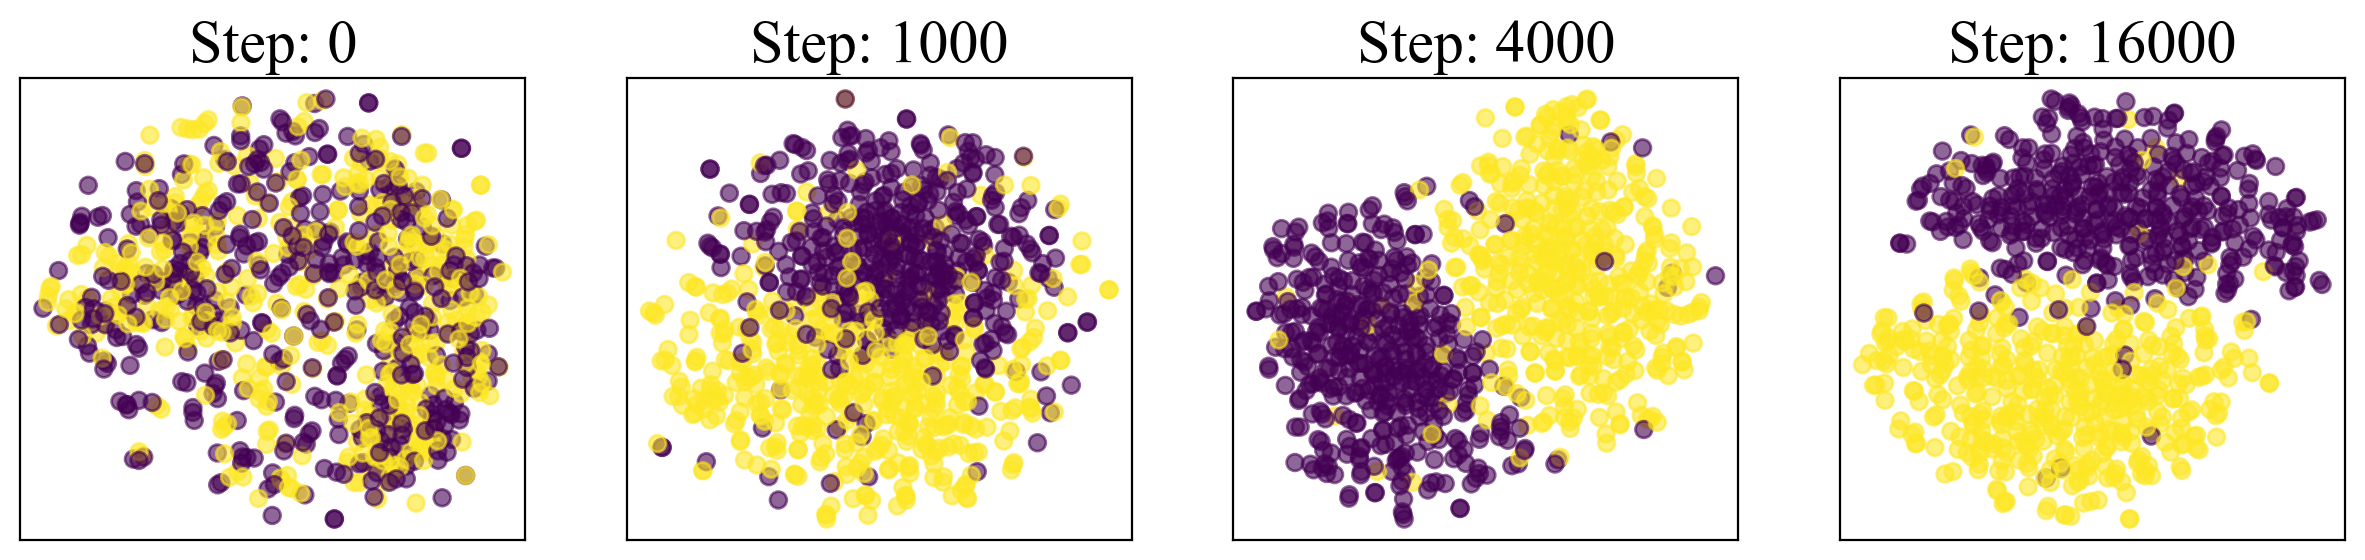

grads 0


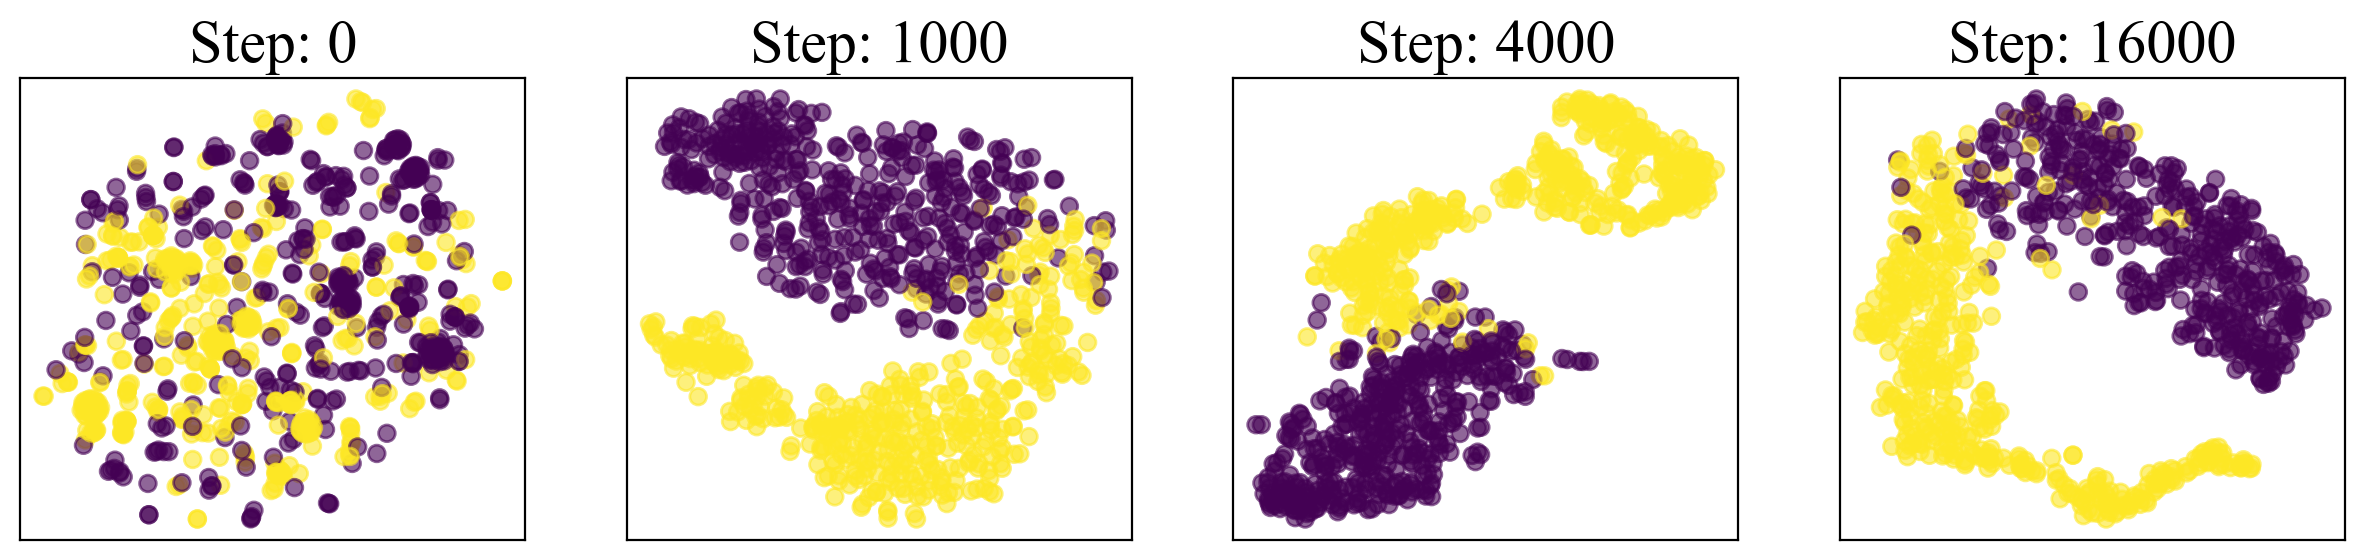

loragrads 0


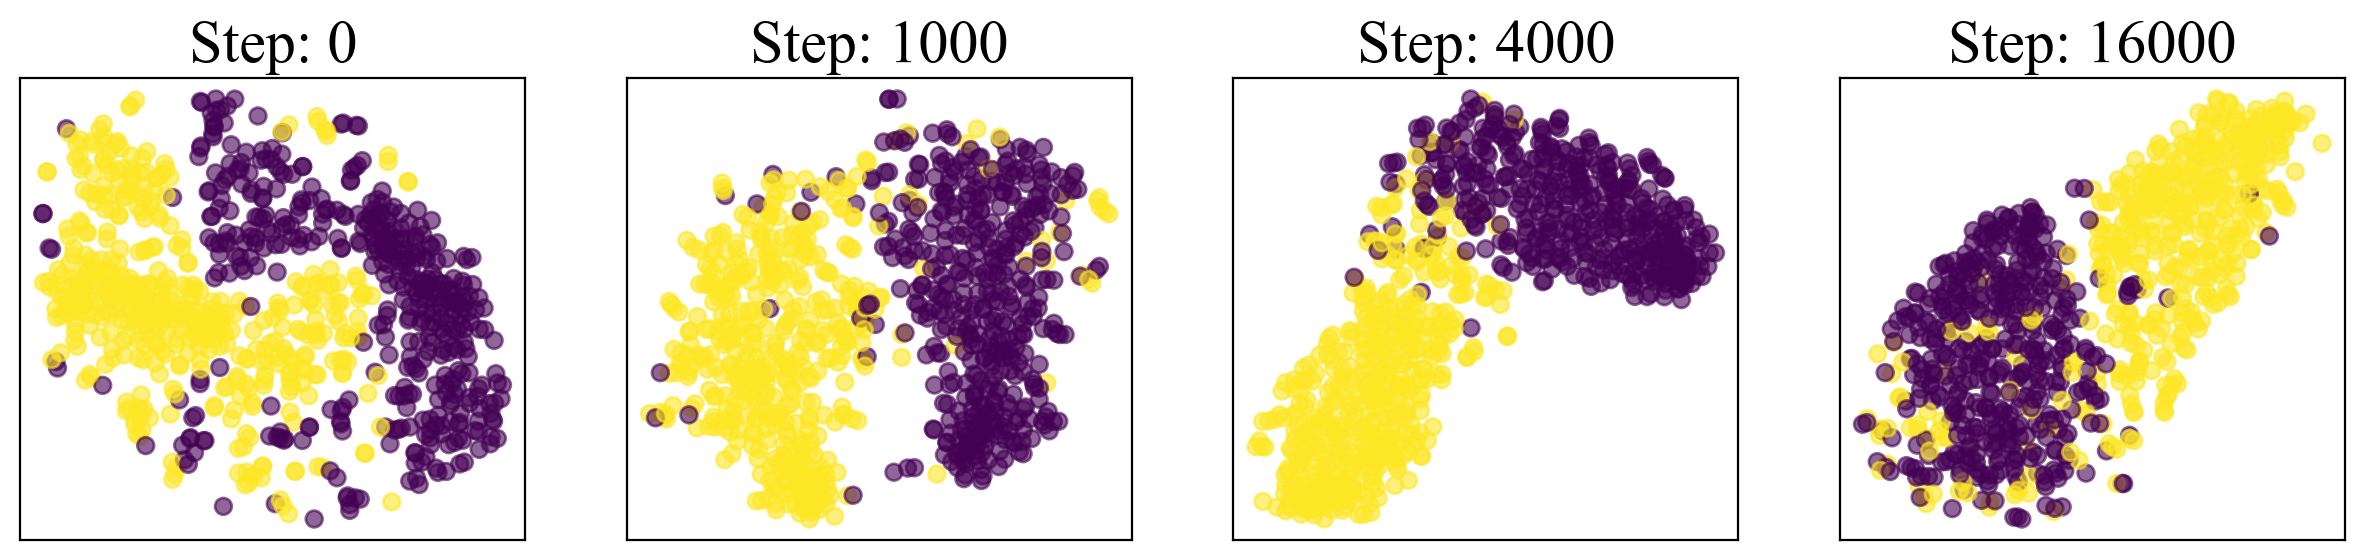

acts 999


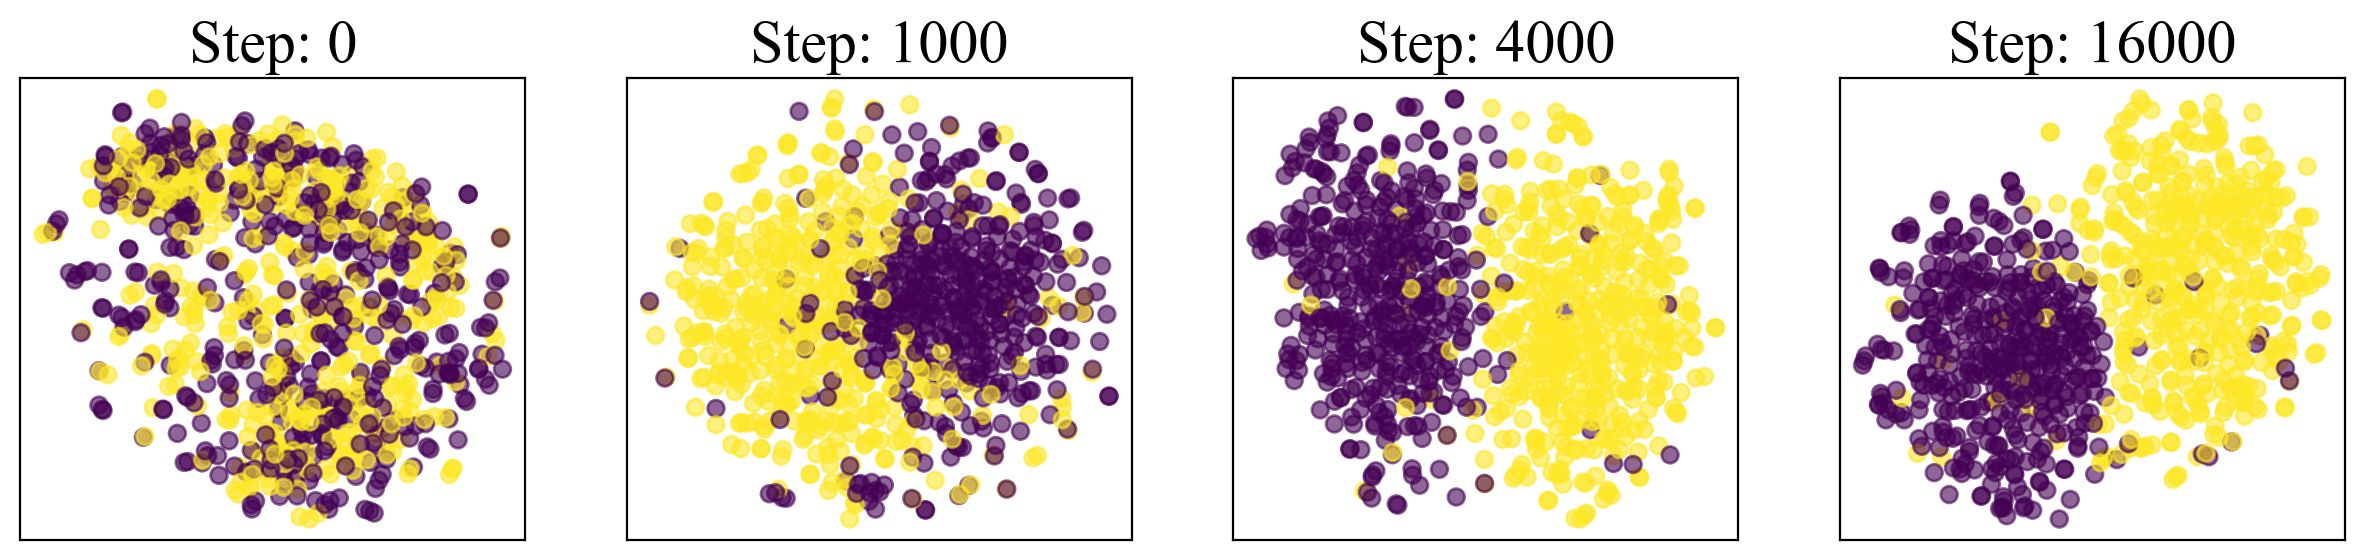

grads 999


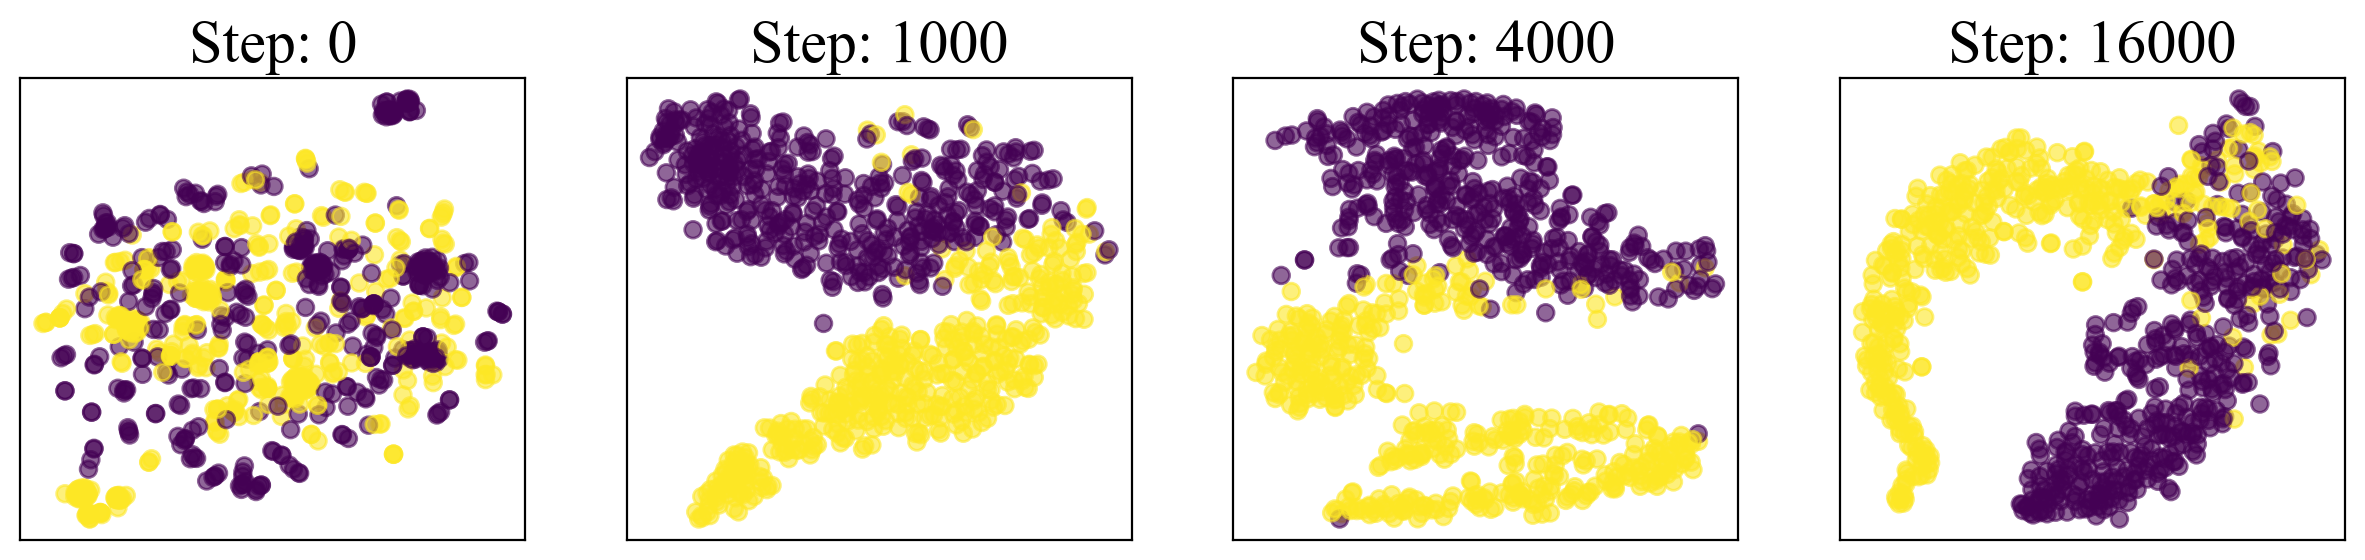

loragrads 999


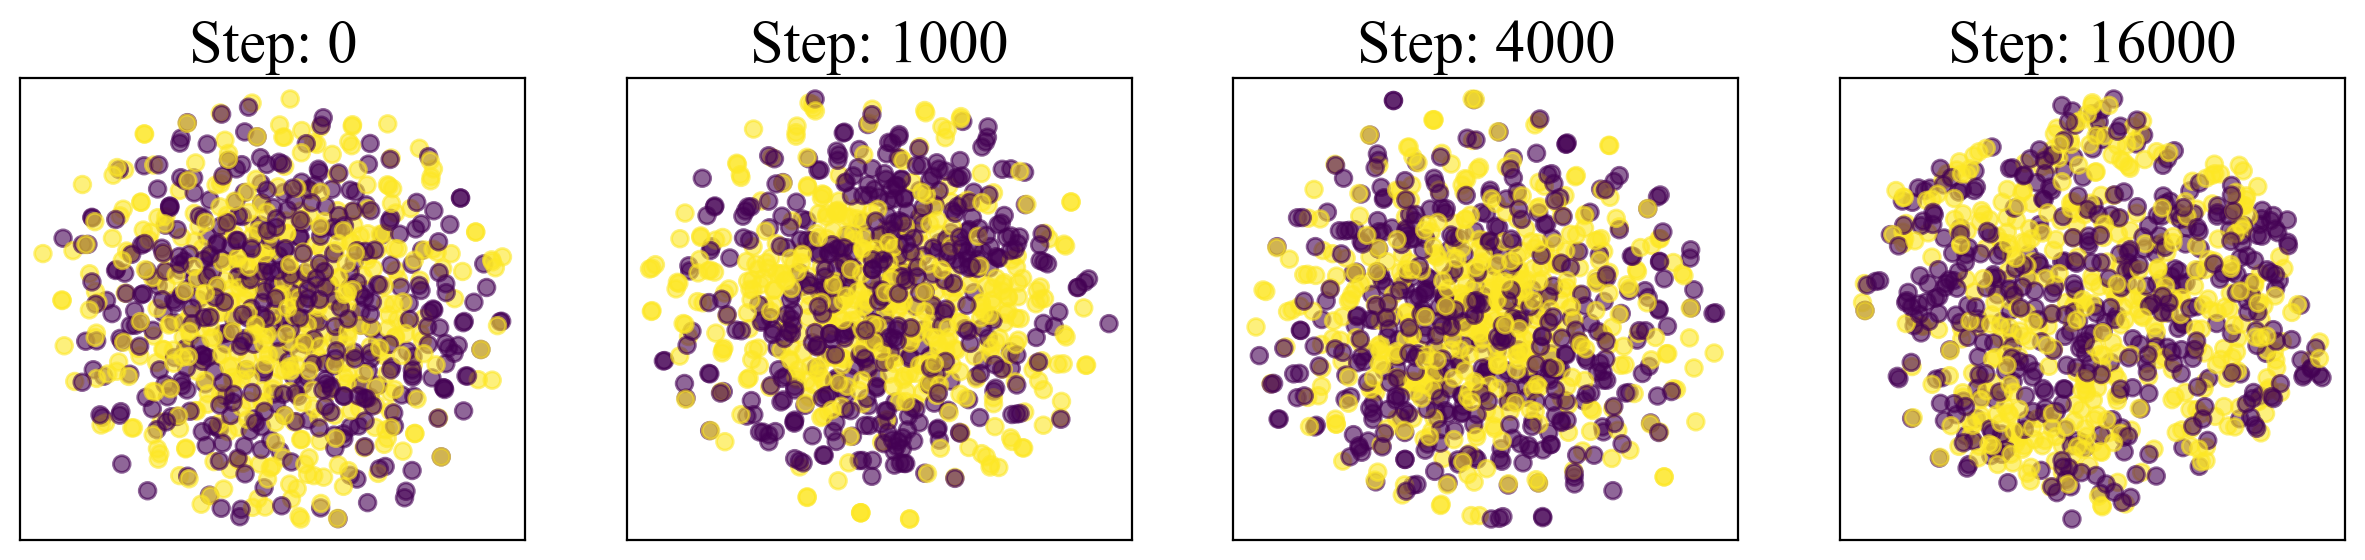

In [78]:
for k_reg in [0, 999]:
    for val in ['acts', 'grads', 'loragrads']:

        print(val, k_reg)
        fig, axs = plt.subplots(1, 4, figsize=(15,3))
        for ax, step in zip(axs, [0, 1000, 4000, 16000]):

            series = chart_data[f"{val}_step_{step}_reg_{k_reg}"]
            labels = chart_data[f"labels_step_{step}_reg_{k_reg}"]
            ax.scatter(series[:,0], series[:,1], c=labels, cmap='viridis', alpha=0.6)
            ax.set_title(f'Step: {step}')
            ax.set_xticks([])
            ax.set_yticks([])
        plt.grid
        plt.savefig(f'pdf/{val}_reg_{k_reg}.pdf', bbox_inches='tight')
        plt.show()